<a href="https://colab.research.google.com/github/tae-yeop/cubox/blob/main/cubox_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<h1 align='center'>Deep Residual Learning for Image Recognition</h1>](https://arxiv.org/pdf/1512.03385.pdf)
<h2 align='center'> Kaiming He Xiangyu Zhang Shaoqing Ren Jian Sun. </h2>


---
# 1. Summary

- The empirical evidences suggest taht deep residual learning, especially identity mapping can be a remedy for the degradation problem and helps to gain better accuracy.

- Based on comprehensive experiments, residual learning framework might be universal approach, not akin to particular dataset.

---
# 2. Motivation

Adding more depth to layers are important for better performance, this technique has critical drawbacks.

1. Vanishing/Exploding gradients
2. Degradation problem

First problem can be addressed by proper weight initialization and batch normalization. But still degratdation prolem occurs ; accuracy gets saturated.

- Residual representation has been effective in Image recognition tasks. This suggests that reformulation in residual way can simplify the optimization.

- Shortcut connection researches have been studied.
  - Highway network has gating mechanism, which impose more complexity compared to the proposed method. ; residual function might not achieved.

---
# 3. Methods



## Residual Learning Framework

let $H(x)$ as desired underlying function. Assume that there exists another mapping of $F(x) :=H(x)-x$. Then we can represent the original mapping as $H(x) = F(x) + x$. It is easire to optimize the function in this seperated setting. To the extreme, if the $H(x)$ is simply identity mapping, then pushing $F(x)$ to 0 will be optimal.


<img src='https://drive.google.com/uc?id=11RnhK-cLxjQU-rtf2-Gtyb6-ACuTvT3m'/>

## Shortcut connection

Two type of shortcut connection are considered to deal with channel dimension.

- Option(A) : $y = \mathcal{F} (x, W_i) + x$
  - indicates the same dimensions of input and output.
  - zero padding for increasing dimensions.
  - In two layer setting : $\mathcal{F} = W_2 \sigma(W_1 x)$
  - seond `ReLU` applied after the elementary-wise addition.

- Option(B) : $ y = \mathcal{F} (x, W_i) + W_s x$
  - projection layer $W_s$ with conv1d to match dimensions.


## Residual Network

<img src="https://drive.google.com/uc?id=1-LNQNlsytCqBlZvlfAhdid0CFbrX7BIw">

- The identity shortcuts can be directly used when input and output are of same dimension.

- When dimensions increase
  - Option (A): zero-padding to perform idenetity mapping
  - Option (B) : projection shortcut done by 1x1 conv.
  - When the shortcuts go across feature maps of two sizes, then conv with stride of 2. (Downsampling)

---
# 4. Experiments



## CIFAR-10

Architecure
-  The first layer is 3×3 conv
-  a stack of 6n layers with 3×3 convolutions on the feature maps of sizes {32, 16, 8} respectively,
with 2n layers for each feature map size.
- A global average pooling -> a 10-way dense layer -> and softmax.
- only use Option (A)
- He weight initializtion. 
- Batch Normalization
- No dropout

Optimization
- weighy decay of 0.0001 and momentum of 0.9.
- Batch size of 128
- start learning rate : 0.1 
- divide it by 10 at 32k and 48k iterations, and
terminate training at 64k iterations

Data augmentation
  - For training : 
    - 4 pixels padded on each side.
    - 32x32 random crop and horizontal flip
  - For testing : 
    - the original 32×32 image


Results


[<img src='https://drive.google.com/uc?id=18aaUvGBwLmU1J988OSJjHc5tBd-A_YVC'/>](https://drive.google.com/file/d/18aaUvGBwLmU1J988OSJjHc5tBd-A_YVC/view?usp=sharing)


ResNets manage to overcome the optimization difficulty and demonstrate accuracy gains when the depth increases.


### Implementation

1. For [stability issue](https://stackoverflow.com/questions/57516027/does-pytorch-apply-softmax-automatically-in-nn-linear), use `nn.CrossEntropyLoss` as the loss function to the output of last layer `nn.Linear()` instead of using nn.Softmax() directly.
2.  Use `nn.AdaptiveAvgPool2d` for GAP. (https://underflow101.tistory.com/41)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [2]:
def set_random_seed(seed, deterministic=False):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seed(77, True)
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
train_transform = transforms.Compose([transforms.RandomCrop(32, 4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

train_set = torchvision.datasets.CIFAR10(root='/data', train=True,
                                        download=True, transform=train_transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

batch_size=128

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,  shuffle=False, num_workers=4, pin_memory=True)
                                        

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
images.shape

torch.Size([128, 3, 32, 32])

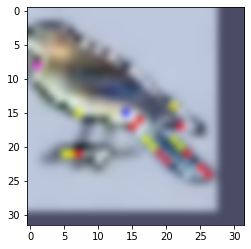

In [8]:
plt.imshow(transforms.ToPILImage()(images[10]/2 + 0.5), interpolation="bicubic")

In [9]:
# https://discuss.pytorch.org/t/how-to-implement-keras-layers-core-lambda-in-pytorch/5903
class LambdaLayer(nn.Module):
  def __init__(self, lambd):
      super(LambdaLayer, self).__init__()
      self.lambd = lambd
  def forward(self, x):
      return self.lambd(x)

In [10]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, filters, kernel_size, subsample=False):
    super(ResidualBlock, self).__init__()
    if subsample is False:
      self.conv1 = nn.Conv2d(in_channels, filters, kernel_size, padding='same')
      self.shortcut = nn.Sequential()
    else:
      self.conv1 = nn.Conv2d(in_channels, filters, kernel_size, stride=2, padding=1)
      self.shortcut = LambdaLayer(lambda x: F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, filters//4, filters//4), "constant", 0))
    
    self.conv2 = nn.Conv2d(filters, filters, kernel_size, padding='same')
    self.bn1 = nn.BatchNorm2d(filters)
    self.bn2 = nn.BatchNorm2d(filters)
    
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)) + self.shortcut(x))
    return out

In [11]:
class ResNet(nn.Module):
  def __init__(self, in_channels=3, n=3, num_classes=10):
    super(ResNet, self).__init__()
    self.num_blk = n
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding='same')
    self.conv_block1 = self._create_conv_block(16, 16, False)
    self.conv_block2 = self._create_conv_block(16, 32, True)
    self.conv_block3 = self._create_conv_block(32, 64, True)
    self.pool = nn.AdaptiveAvgPool2d((1))
    self.fc = nn.Linear(64, num_classes)
    
    self._reset_parameters()

  def _reset_parameters(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      
  def _create_conv_block(self, in_channels, filters, subsample):
    layer = []
    if subsample is False:
      for i in range(self.num_blk):
        layer.append(ResidualBlock(in_channels, filters, 3, False))
    else:
      layer.append(ResidualBlock(in_channels, filters, 3, True))
      for i in range(self.num_blk-1):
        layer.append(ResidualBlock(filters, filters, 3, False))

    return nn.Sequential(*layer)

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv_block1(out)
    out = self.conv_block2(out)
    out = self.conv_block3(out)
    out = self.pool(out)
    out = torch.flatten(out, start_dim=1)
    out = self.fc(out)
    return out

In [12]:
resnet = ResNet().to(device)

In [13]:
summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 16, 32, 32]           2,320
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
     ResidualBlock-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,320
       BatchNorm2d-8           [-1, 16, 32, 32]              32
            Conv2d-9           [-1, 16, 32, 32]           2,320
      BatchNorm2d-10           [-1, 16, 32, 32]              32
    ResidualBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,320
      BatchNorm2d-13           [-1, 16, 32, 32]              32
           Conv2d-14           [-1, 16,

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), weight_decay = 0.0001, momentum=0.9, lr=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3200,4800], gamma=0.1)
print_freq = 100
save_every = 100
epochs = 10 # 6400

In [15]:
acc_history = []
for epoch in range(epochs):
  train_loss = 0
  correct = 0
  total = 0
  for i, (inputs, targets) in enumerate(train_loader, 0):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = resnet(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
    accuracy = correct/total *100
    acc_history.append(accuracy)
    if i % print_freq == 0:
      print(f"Epoch : {epoch}, Batch: {i}/{len(train_loader)} Loss : {train_loss/(i + 1)} Acc : {accuracy}")
  scheduler.step()
  
  if epoch % save_every == 0:
    torch.save(resnet.state_dict(),'checpoint.pth')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : 0, Batch: 0/391 Loss : 2.733283281326294 Acc : 7.8125
Epoch : 0, Batch: 100/391 Loss : 1.9827831523253185 Acc : 25.750309405940598
Epoch : 0, Batch: 200/391 Loss : 1.8188852955452839 Acc : 31.704757462686565
Epoch : 0, Batch: 300/391 Loss : 1.7137734478098214 Acc : 35.68054401993355
Epoch : 1, Batch: 0/391 Loss : 1.380615234375 Acc : 49.21875
Epoch : 1, Batch: 100/391 Loss : 1.2642561822834582 Acc : 54.014542079207914
Epoch : 1, Batch: 200/391 Loss : 1.2218618238743264 Acc : 55.80690298507462
Epoch : 1, Batch: 300/391 Loss : 1.1769823079489394 Acc : 57.46470099667774
Epoch : 2, Batch: 0/391 Loss : 1.1502963304519653 Acc : 60.9375
Epoch : 2, Batch: 100/391 Loss : 0.9891868540556124 Acc : 64.57301980198021
Epoch : 2, Batch: 200/391 Loss : 0.9601902078040203 Acc : 65.70662313432835
Epoch : 2, Batch: 300/391 Loss : 0.937030090644114 Acc : 66.54640780730897
Epoch : 3, Batch: 0/391 Loss : 0.6801171898841858 Acc : 72.65625
Epoch : 3, Batch: 100/391 Loss : 0.827189300319936 Acc : 70.54

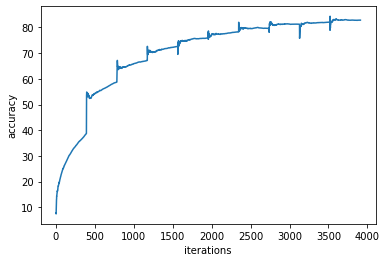

In [18]:
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(acc_history)+1), acc_history)
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()

In [19]:
# Inference
img, label = next(iter(test_loader))
img = img[0:10].to(device)
label = label[0:10]
out = resnet(img)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
import numpy as np
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


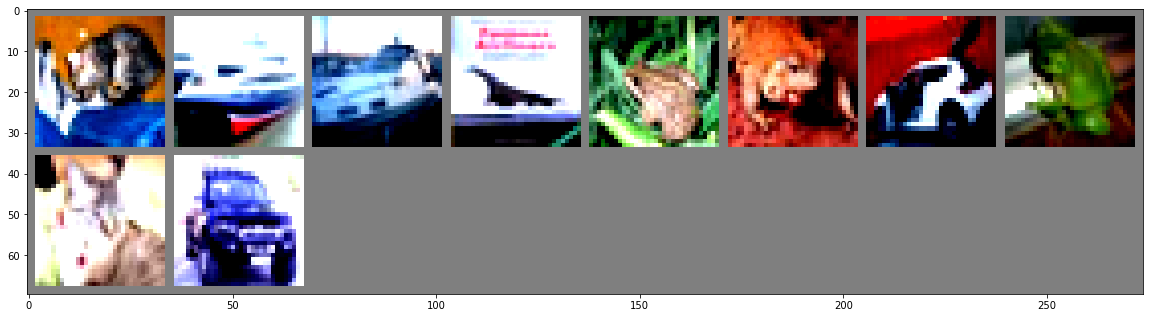

In [21]:
plt.figure(figsize=(20,10)) 
imshow(torchvision.utils.make_grid(img.cpu()))

In [22]:
# Groud truth
print(' '.join(classes[i] for i in label))

cat ship ship plane frog frog car frog cat car


In [23]:
out.argmax(1)

tensor([3, 8, 8, 0, 6, 5, 1, 2, 3, 1], device='cuda:0')

In [24]:
# Predition
print(' '.join(classes[i] for i in out.argmax(1)))

cat ship ship plane frog dog car bird cat car


---
## ImageNet



### Performance of Classification

It shows the degradation problem is well addressed. 

<img src='https://drive.google.com/uc?id=1EsaDM2ytXAVjlPG-B0iuqBt16VT8mviT'>
<img src='https://drive.google.com/uc?id=1COWK-No3ReOVfM8ipB8XB3vRhI7yeZlT'/>

Resnet-18, Resnet-34 : |a shortcut connection is added to each pair of 3x3 filters. Use identity mapping for all shortcuts and option(A)

### Identity vs Projection Shortcuts

Tested with 3 variant shortcut options. All 3 are better than the plain baseline. But the difference is small.

<img src='https://drive.google.com/uc?id=1QqQNK_2XidXmhfncP3PSDoGPjX4HkinM'/>

Deeper resnet are of option B for increasing dimensions.

### Deeper Bottleneck Architecrue

Use 3-layer bottleneck blocks instead of 2-layer block to reduce complexity.
Apply Option(B) only when dimension matching is neeeded.

<img src='https://drive.google.com/uc?id=1G-QZEMX8Cc8ILulqVYn2jD9aH2Oikq6w'/>

- First 1x1 conv : reducing dimensions.
- Second 1x1 conv : restoring dimensions.
- Identity shortcut is prefered in bottlenet setting.

Resnet-101, 152 stll less complexity than VGG 16/19.


### Implmentation

Architecture
- Apply Batch Normalization right after each conv and before activation. 
- Weight Initialization
- No dropout

Optimizer
- SGD
- batch size of 256.
- start learning rate : 0.1
- lr decay divided by 10 when the error plateaus
- weight decay : 0.0001
- momentum : 0.9
- epoch : 600,000

Data Augmentation
- 224 x 224 random crop
- horizontal flip
- per-pixel mean substracted
- color augmentation

In testing, for comparison studies we adopt the standard
10-crop testing [21]. For best results, we adopt the fullyconvolutional form as in [41, 13], and average the scores
at multiple scales (images are resized such that the shorter
side is in {224, 256, 384, 480, 640}).

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [26]:
def set_random_seed(seed, deterministic=False):
    # random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seed(77, True)
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [32]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, filters, subsample):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, filters, 1)
    self.bn1 = nn.BatchNorm2d(filters)
    if subsample is True:
      stride = 2
    else:
      stride = 1
    self.conv2 = nn.Conv2d(filters, filters, 3, stride, padding=1)
    self.bn2 = nn.BatchNorm2d(filters)
    self.conv3 = nn.Conv2d(filters, filters*4, 1)
    self.bn3 = nn.BatchNorm2d(filters*4)
    self.shortcut = nn.Sequential()

    if subsample is True or in_channels != filters*4:
      self.shortcut = nn.Sequential(nn.Conv2d(in_channels, 4*filters, 1, stride),
                                    nn.BatchNorm2d(4*filters))

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = F.relu(self.bn3(self.conv3(out)))
    out = F.relu(out + self.shortcut(x))
    return out

In [33]:
class ResNet50(nn.Module):
  def __init__(self, in_channels=3, num_classes=1000):
    super(ResNet50, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, padding=1, stride=2)
    self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

    self.conv_block1 = self._create_conv_block(64, 64, [False, False, False])
    self.conv_block2 = self._create_conv_block(256, 128, [True, False, False, False] )
    self.conv_block3 = self._create_conv_block(512, 256, [True, False, False, False, False, False])
    self.conv_block4 = self._create_conv_block(1024, 512, [True, False, False])
    self.pool = nn.AdaptiveAvgPool2d((1))
    self.fc = nn.Linear(2048, num_classes)
    
    self._reset_parameters()

  def _reset_parameters(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      
  def _create_conv_block(self, in_channels, filters, subsample_list):
    layers = []
    for subsample in subsample_list:
      layers.append(ResidualBlock(in_channels, filters, subsample))
      in_channels = filters * 4
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv_block1(out)
    out = self.conv_block2(out)
    out = self.conv_block3(out)
    out = self.conv_block4(out)
    out = self.pool(out)
    out = torch.flatten(out, start_dim=1)
    out = self.fc(out)
    return out

In [36]:
resnet = ResNet50().to(device)

In [37]:
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,472
            Conv2d-2         [-1, 64, 110, 110]           4,160
       BatchNorm2d-3         [-1, 64, 110, 110]             128
            Conv2d-4         [-1, 64, 110, 110]          36,928
       BatchNorm2d-5         [-1, 64, 110, 110]             128
            Conv2d-6        [-1, 256, 110, 110]          16,640
       BatchNorm2d-7        [-1, 256, 110, 110]             512
            Conv2d-8        [-1, 256, 110, 110]          16,640
       BatchNorm2d-9        [-1, 256, 110, 110]             512
    ResidualBlock-10        [-1, 256, 110, 110]               0
           Conv2d-11         [-1, 64, 110, 110]          16,448
      BatchNorm2d-12         [-1, 64, 110, 110]             128
           Conv2d-13         [-1, 64, 110, 110]          36,928
      BatchNorm2d-14         [-1, 64, 1